# Using Autoencoder as Anomaly Detection
This notebook is for training and understanding purposes only. All algorithms and credits go to pyimagesearch.com, specifically https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/ and Adrian Rosebrock (A wonderful source and inspiration for Computer Vision and Deep Learning)

As this notebook is for training and understanding purposes, rather than downloading the source code right away. The code will be typed in order to build "muscle-memory". Author-readable comments will appear from time to time.

Autoencoder is used to compress data in an unsupervised manner efficiently. It is a feedforward artifical neural network that consists of three steps: (a) encode, (b) code, (c) decode. 
<br>
a. encode requires an encoding scheme <br>
b. decode requires a loss function to compare if the input and decoded target are the same

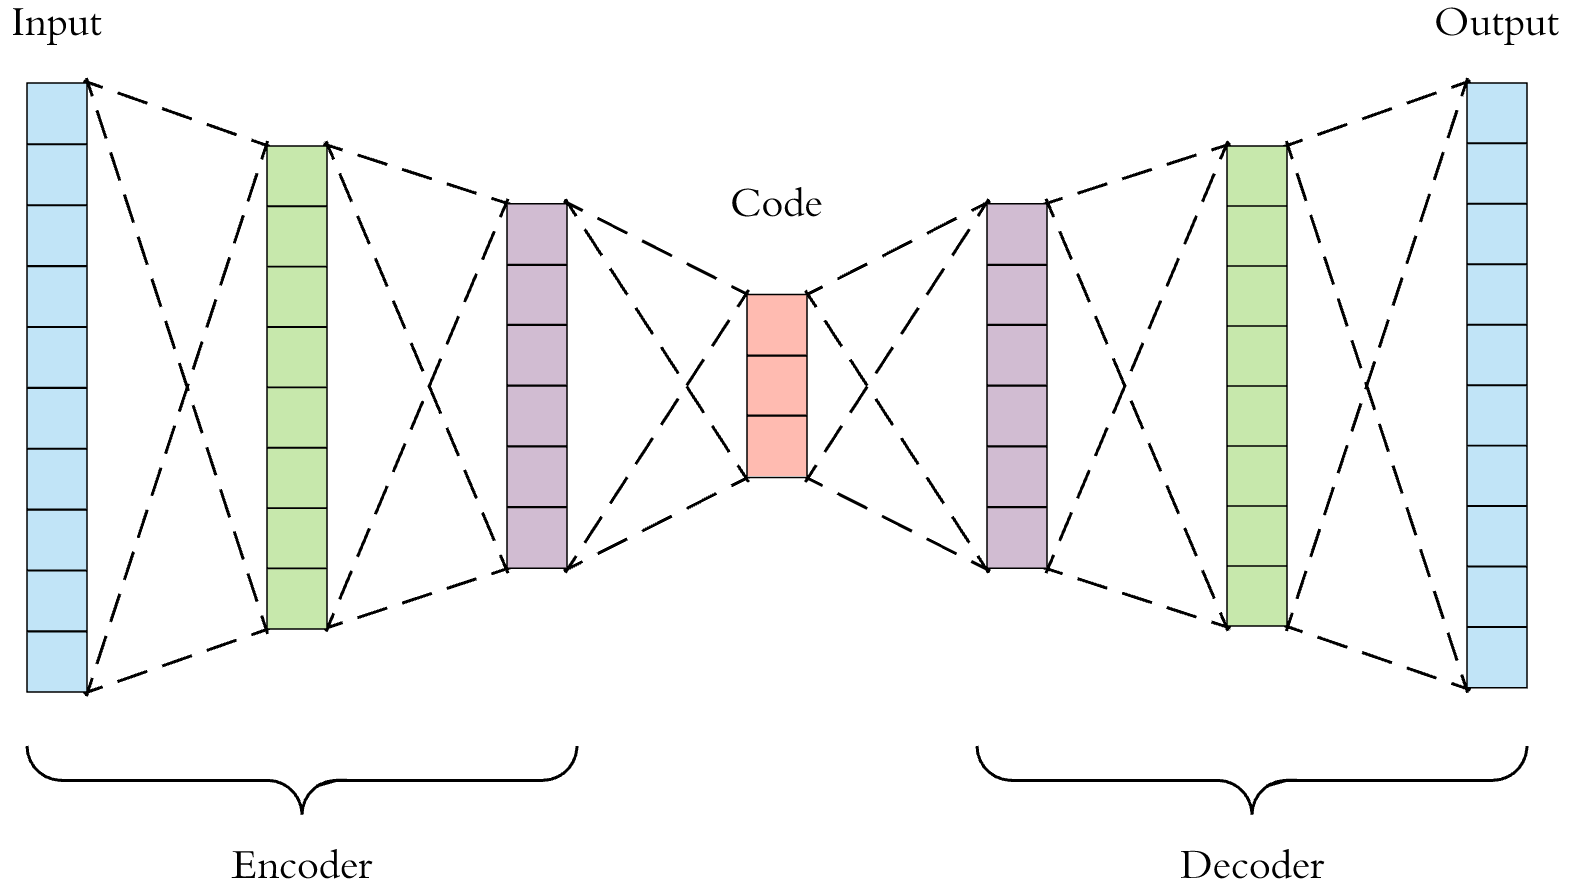
Because autoencoder only works on the data that it has been trained on, any outlier/anomaly data would failed to decode properly and yield a high loss function

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
    # in this class, we are building a tensorflow model from scratch, thus,
    # (1) import all required layers
    # (2) add layers after the other (similar to cast method i.e. layer1(layer2))
    # (3) compile all layers and input into Sequential Model
    
    @staticmethod
    # similar to C# the staticmethod attribute allows the function to be called directly
    # i.e. ConvAutoencoder.build(foo)
    # rather than object = ConvAutoencoder, object.build(foo)
    
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        # width, height, depth are inputs of image
        # filters are numbers of filters in the encoding and decoding portion. These are typically randomly distributed around mean 0
        # latentDimension is the encoded dimensionality
        
        inputShape = (height, width, depth)
        # channel dimensions is closely related to the input shape, as Keras could use different backend
        # the input could be (x,y,z,channels) or (channels,x,y,z)
        # in our case, we have explicitly call for channels to be last. why is this important? because
        # when we do batch normalization, we would have to call for which axis to be normalized
        chanDim = -1
        
        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            # this is a 2 hidden layer neural network
            # 1st layer consists of 32 Conv2D kernels, followed by an Leaky ReLU activation function, then the batch is normalized
            # 2nd layer consists of 64 Conv2D kernels, followed by an Leaky ReLU activation function, then the batch is normalized
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        # returns shape of final layer x (could be tuple, could be int). why is this important? because
        # we need to reconstruct the shape for decoder portion
        # flatten the network. When we flatten our network we have an effective (channel)(x)(y)(z) vector
        # then, we would use a dense matrix to force it to 16-elements vector
        volumeSize = K.int_shape(x)
        print(volumeSize)
        x = Flatten()(x)
        
        # final layer for the encoder portion 
        latent = Dense(latentDim)(x)
        # build the encoder model
        encoder = Model(inputs, latent, name="encoder")
        
        # start building the decoder model which will accept the output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        # loop over our number of filters again, but this time in reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            # we reverse the number of filters to rebuild the original image size
            x = Conv2DTranspose(f, (3, 3), strides=2,padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        # apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        
        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")
        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
        
        return (encoder, decoder, autoencoder)

In [6]:
# script to build a dataset

import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
#import ConvAutoencoder
import argparse
import random
import pickle
import cv2

%matplotlib inline

def build_unsupervised_dataset(data, labels, validLabel=1, anomalyLabel=3, contam=0.01, seed=42):
    # data and labels are numpy array, validLabel and anomalyLabel is an integer for MNIST data
    # contam is the percentage which our dataset has anomalies
    # there is an assumption to which the data and labels are of the same size
    # since autoencoder are highly data-specific, any anomaly index can be used
    validIdxs = np.where(labels == validLabel)[0]
    anomalyIdxs = np.where(labels == anomalyLabel)[0]
    
    # randomly shuffle both sets of indexes
    random.shuffle(validIdxs)
    random.shuffle(anomalyIdxs)
    
    # compute the total number of anomaly data points to select
    i = int(len(validIdxs) * contam)
    anomalyIdxs = anomalyIdxs[:i]
    
    # use NumPy array indexing to extract both the valid images and "anomaly" images
    validImages = data[validIdxs]
    anomalyImages = data[anomalyIdxs]
    
    # stack the valid images and anomaly images together to form a
    # single data matrix and then shuffle the rows
    images = np.vstack([validImages, anomalyImages])
    np.random.seed(seed)
    np.random.shuffle(images)
    # return the set of images
    return images

def visualize_predictions(decoded, gt, samples=10):
    # visualizing function for comparing original and decoded images
    # decoded is the image/prediction obtained from the autoencoder
    # gt is the test images
    
    # this is a cool trick here. Instantiate a "null" object then stack horizontally for the comparison
    # and stack vertically for comparison between samples
    outputs = None
    
    for i in range(0, samples):
        
        original = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")
        
        output = np.hstack([original, recon])
        
        if outputs is None:
            outputs = output
        else:
            outputs = np.vstack([outputs, output])
    
    return outputs

# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", type=str, required=True, help="path to output dataset file")
#ap.add_argument("-m", "--model", type=str, required=True, help="path to output trained autoencoder")
#ap.add_argument("-v", "--vis", type=str, default="recon_vis.png", help="path to output reconstruction visualization file")
#ap.add_argument("-p", "--plot", type=str, default="plot.png", help="path to output plot file")
#args = vars(ap.parse_args())

[INFO] loading MNIST dataset...
[INFO] creating unsupervised dataset...
[INFO] building autoencoder...
(None, 7, 7, 64)
Train on 5932 samples, validate on 1484 samples
Epoch 1/20
5932/5932 [==============================] - 11s 2ms/sample - loss: 0.0444 - val_loss: 0.0467
Epoch 2/20
5932/5932 [==============================] - 10s 2ms/sample - loss: 0.0110 - val_loss: 0.0316
Epoch 3/20
5932/5932 [==============================] - 10s 2ms/sample - loss: 0.0057 - val_loss: 0.0082
Epoch 4/20
5932/5932 [==============================] - 10s 2ms/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 5/20
5932/5932 [==============================] - 10s 2ms/sample - loss: 0.0042 - val_loss: 0.0045
Epoch 6/20
5932/5932 [==============================] - 10s 2ms/sample - loss: 0.0040 - val_loss: 0.0043
Epoch 7/20
5932/5932 [==============================] - 10s 2ms/sample - loss: 0.0036 - val_loss: 0.0045
Epoch 8/20
5932/5932 [==============================] - 10s 2ms/sample - loss: 0.0035 - val_loss:

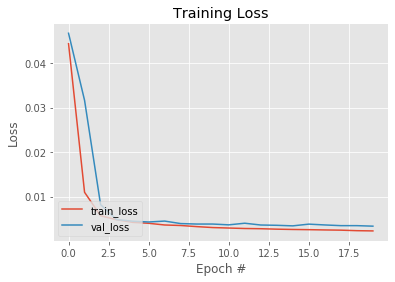

In [35]:

# initialize the number of epochs to train for, initial learning rate, and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()
print("[INFO] creating unsupervised dataset...")
images = build_unsupervised_dataset(trainX, trainY, validLabel=1, anomalyLabel=5, contam=0.1)

# add a channel dimension to every image in the dataset, then scale the pixel intensities to the range [0, 1]
# we do that because our conv neural net takes in RGB data (as you can see on model.build)
# np.expand dims create an empty "array"
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

# uses sklearn train_test_split to split the full dataset to training and testing
(trainX, testX) = train_test_split(images, test_size=0.2, random_state=42)

print("[INFO] building autoencoder...")
# if we want to change to different image, change the following image size
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)
H = autoencoder.fit(trainX, trainX, validation_data=(testX, testX), epochs=EPOCHS, batch_size=BS)
# use the convolutional autoencoder to make predictions on the testing images, construct the visualization, and then save it to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
#cv2.imwrite(args["vis"], vis)

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
# serialize the image data to disk
#print("[INFO] saving image data...")
#f = open(args["dataset"], "wb")
#f.write(pickle.dumps(images))
#f.close()
# serialize the autoencoder model to disk
#print("[INFO] saving autoencoder...")
#autoencoder.save(args["model"], save_format="h5")

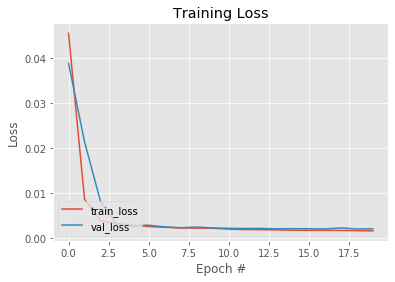

In [12]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [ ]:
vis = visualize_predictions(decoded, testX, samples=10)
plt.figure(figsize=(20,100))
plt.imshow(vis[:,:,0], cmap="gray")